In [2]:
import pandas as pd


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install --upgrade google-cloud-bigquery[pandas]

Requirement already up-to-date: google-cloud-bigquery[pandas] in c:\users\pc\anaconda3\lib\site-packages (1.24.0)
Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext google.cloud.bigquery

In [4]:
# set GOOGLE_APPLICATION_CREDENTIALS to serveice account that was created by me
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="korsunkonserv.json"

# Now we can use SQL query directly from jupiter notebook and save it as pandas dataframes. It this query we will investigate connection between stringency index and deaths. We hope to find negative correlation(when stringency index increased deaths have to decrease).
Stringency index -nine-point aggregation of the eight containment and closure indicators as well as H1 (public information campaigns). It reports a number between 0 to 100 that reflects the overall stringency of the governments response. This is a measure of how many of the these nine indicators (mostly around social isolation) a government has acted upon, and to what degree.

In [5]:
%%bigquery str_covid
SELECT country_name,stringency_index,confirmed_cases,deaths
FROM `bigquery-public-data.covid19_govt_response.oxford_policy_tracker` 
WHERE date='2020-05-20'


In [6]:
str_covid.head()

,country_name,stringency_index,confirmed_cases,deaths
0,Angola,81.61,50.0,2.0
1,Albania,88.36,949.0,31.0
2,United Arab Emirates,77.78,25063.0,227.0
3,Argentina,91.54,8796.0,393.0
4,Burundi,22.22,42.0,1.0


In [7]:
# inspect dtypes
str_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country_name      166 non-null    object 
 1   stringency_index  165 non-null    float64
 2   confirmed_cases   165 non-null    float64
 3   deaths            165 non-null    float64
dtypes: float64(3), object(1)
memory usage: 5.3+ KB


In [8]:
#Find rows with Nan
is_NaN = str_covid.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = str_covid[row_has_NaN]

In [9]:
# It is better to fill nan with zero in case of Solomon Islands, because there are no confirmed cases there. 
#And we should drop Lithuania,because we don't have  stringency_index for this country,aand it is certanly not zero
print(rows_with_NaN)

        country_name  stringency_index  confirmed_cases  deaths
48         Lithuania               NaN           1562.0    60.0
113  Solomon Islands             50.41              NaN     NaN


In [10]:
#fill nan with zero
str_covid=str_covid.fillna(0)

In [11]:
#drop Lithuania
str_covid=str_covid.drop(54)

In [12]:
str_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 0 to 165
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country_name      165 non-null    object 
 1   stringency_index  165 non-null    float64
 2   confirmed_cases   165 non-null    float64
 3   deaths            165 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.4+ KB


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


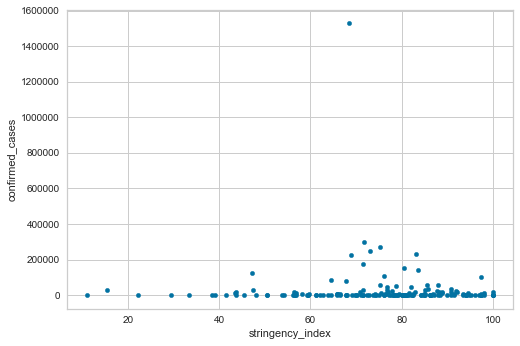

In [50]:
str_covid.plot.scatter(x='stringency_index', y='confirmed_cases')

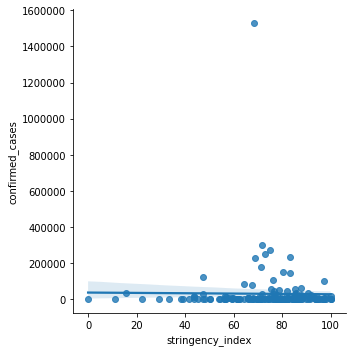

In [15]:
# Here we cannot see clear correlation between stringency index and confirmed cases
ax=sns.lmplot(x='stringency_index', y='confirmed_cases',data=str_covid)
ax.set_xlabels('stringency_index')
ax.set_ylabels('confirmed_cases')

In [17]:
str_covid.corr().head()

,stringency_index,confirmed_cases,deaths
stringency_index,1.000000,-0.013132,-0.010627
confirmed_cases,-0.013132,1.000000,0.930097
deaths,-0.010627,0.930097,1.000000


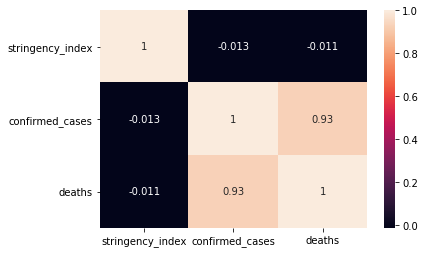

In [18]:
#plot correl matrix. Also no correlation. 
corrMatrix = str_covid.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Generally it dont mean anything because there are real ploblems in counting cases and deaths from covid in different countries. For example in Russia there is suspiciously low deaths rating,same situation in Belarus. I am doing this research mostly in educational purposes(train clustering and SQL).

In [20]:
# Now we will use clustering to detrmine groups of countries based on covid situation
from pycaret.clustering import *

In [22]:
clust = setup(str_covid, normalize = True, 
                                     )


Setup Succesfully Completed!


,Description,Value
0,session_id,1433
1,Original Data,"(165, 4)"
2,Missing Values,False
3,Numeric Features,3
4,Categorical Features,1
5,Ordinal Features,False
6,High Cardinality Features,False
7,Transformed Data,"(165, 168)"
8,Numeric Imputer,mean
9,Categorical Imputer,constant


In [23]:
# We will use k means clustering
kmeans = create_model('kmeans')

In [24]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1433, tol=0.0001, verbose=0)


In [25]:
kmean_results = assign_model(kmeans)
kmean_results.head()

,country_name,stringency_index,confirmed_cases,deaths,Cluster
0,Myanmar,79.24,193.0,6.0,Cluster 1
1,Seychelles,65.87,11.0,0.0,Cluster 0
2,Bulgaria,63.89,2292.0,116.0,Cluster 0
3,Angola,81.61,50.0,2.0,Cluster 1
4,Albania,88.36,949.0,31.0,Cluster 1


In [44]:
cluster3=kmean_results[kmean_results['Cluster']=='Cluster 3']

In [45]:
cluster3.head()

,country_name,stringency_index,confirmed_cases,deaths,Cluster
33,France,83.46,143427.0,28022.0,Cluster 3
49,Italy,68.78,226699.0,32169.0,Cluster 3
105,Brazil,75.15,271628.0,17971.0,Cluster 3
134,Spain,83.07,232555.0,27888.0,Cluster 3
136,United Kingdom,73.01,248818.0,35341.0,Cluster 3


In [46]:
cluster1=kmean_results[kmean_results['Cluster']=='Cluster 1']
cluster1.head()

,country_name,stringency_index,confirmed_cases,deaths,Cluster
0,Myanmar,79.24,193.0,6.0,Cluster 1
3,Angola,81.61,50.0,2.0,Cluster 1
4,Albania,88.36,949.0,31.0,Cluster 1
5,United Arab Emirates,77.78,25063.0,227.0,Cluster 1
6,Argentina,91.54,8796.0,393.0,Cluster 1


In [40]:
plot_model(kmeans)

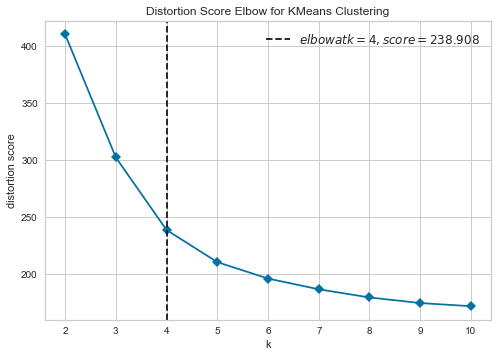

In [27]:
# 4 clusters 
plot_model(kmeans, plot = 'elbow')

In [28]:
#most of countries belong to cluster 1
plot_model(kmeans, plot = 'distribution')

In [29]:
# cluster 1 countries have high stringency_index
plot_model(kmeans, plot = 'distribution', feature = 'stringency_index')

In [42]:
#Also cluster 1 countries have at general low confirmed_cases compared to cluster 3 countries
plot_model(kmeans, plot = 'distribution', feature = 'confirmed_cases')

In [30]:
plot_model(kmeans, plot = 'distribution', feature = 'country_name')

In [31]:
help(plot_model)

Help on function plot_model in module pycaret.clustering:

plot_model(model, plot='cluster', feature=None, label=False)
    Description:
    ------------
    This function takes a trained model object and returns a plot on the dataset 
    passed during setup stage. This function internally calls assign_model before 
    generating a plot.  
    
        Example:
        --------
        from pycaret.datasets import get_data
        jewellery = get_data('jewellery')
        experiment_name = setup(data = jewellery, normalize = True)
        kmeans = create_model('kmeans')
        
        plot_model(kmeans)
    
        This will return a cluster scatter plot (by default). 
    
    Parameters
    ----------
    model : object, default = none
    A trained model object can be passed. Model must be created using create_model().
    
    plot : string, default = 'cluster'
    Enter abbreviation for type of plot. The current list of plots supported are:
    
    Name                      

In [36]:
plot_model(kmeans, plot = 'tsne',label=True,feature = 'stringency_index')

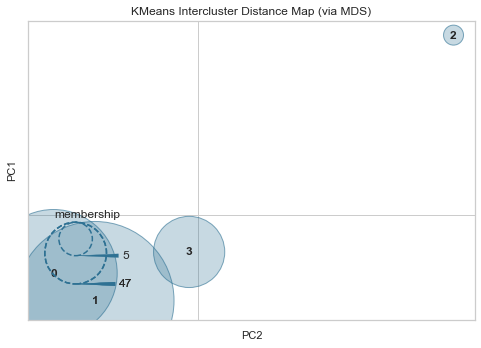

In [33]:
plot_model(kmeans, plot = 'distance')